# Some predictions and plots

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
from importlib import reload

import greyboxmodels.bbmcpsmodels.creator as creator
import greyboxmodels.bbmcpsmodels.cyber.OPF as opf_bbm

# Set the working directory
os.chdir("D:/projects/IPTLC_BBMs/")
print(f"Working directory: {os.getcwd()}")

Working directory: D:\projects\IPTLC_BBMs


In [2]:
# Check GPU availability
device = creator.get_device()
print(device)

cuda:0


In [3]:
# Open the gt data
input_data = np.load("data/OPF/20240311_011412/gt_simulation_0_inputs_minmax_normalized.npy")
output_data = np.load("data/OPF/20240311_011412/gt_simulation_0_outputs_minmax_normalized.npy")

# tensorize the data
input_data = torch.from_numpy(input_data).float().to(device)
output_data = torch.from_numpy(output_data).float().to(device)

# Shape of the data
input_size = input_data.shape[1]
output_size = output_data.shape[1]
print(f"Input data shape: {input_size}")
print(f"Output data shape: {output_size}")

Input data shape: 52
Output data shape: 10


In [4]:
# Load the models
bbm1 = opf_bbm.BBM1_SimpleNet(input_size, output_size)
bbm1.load_state_dict(torch.load("models\BBM1_SimpleNet_MinMaxNormalizedOPF_20240314-114822.pt"))
bbm1.to(device)
_ = bbm1.eval()

bbm2 = opf_bbm.BBM2_DeepNN(input_size, output_size)
bbm2.load_state_dict(torch.load("models\BBM2-deep_MinMaxNormalizedOPF_20240314-120950.pt"))
bbm2.to(device)
_ = bbm2.eval()


In [5]:
# Predictions
pred_inputs = bbm1(input_data)
pred_inputs2 = bbm2(input_data)

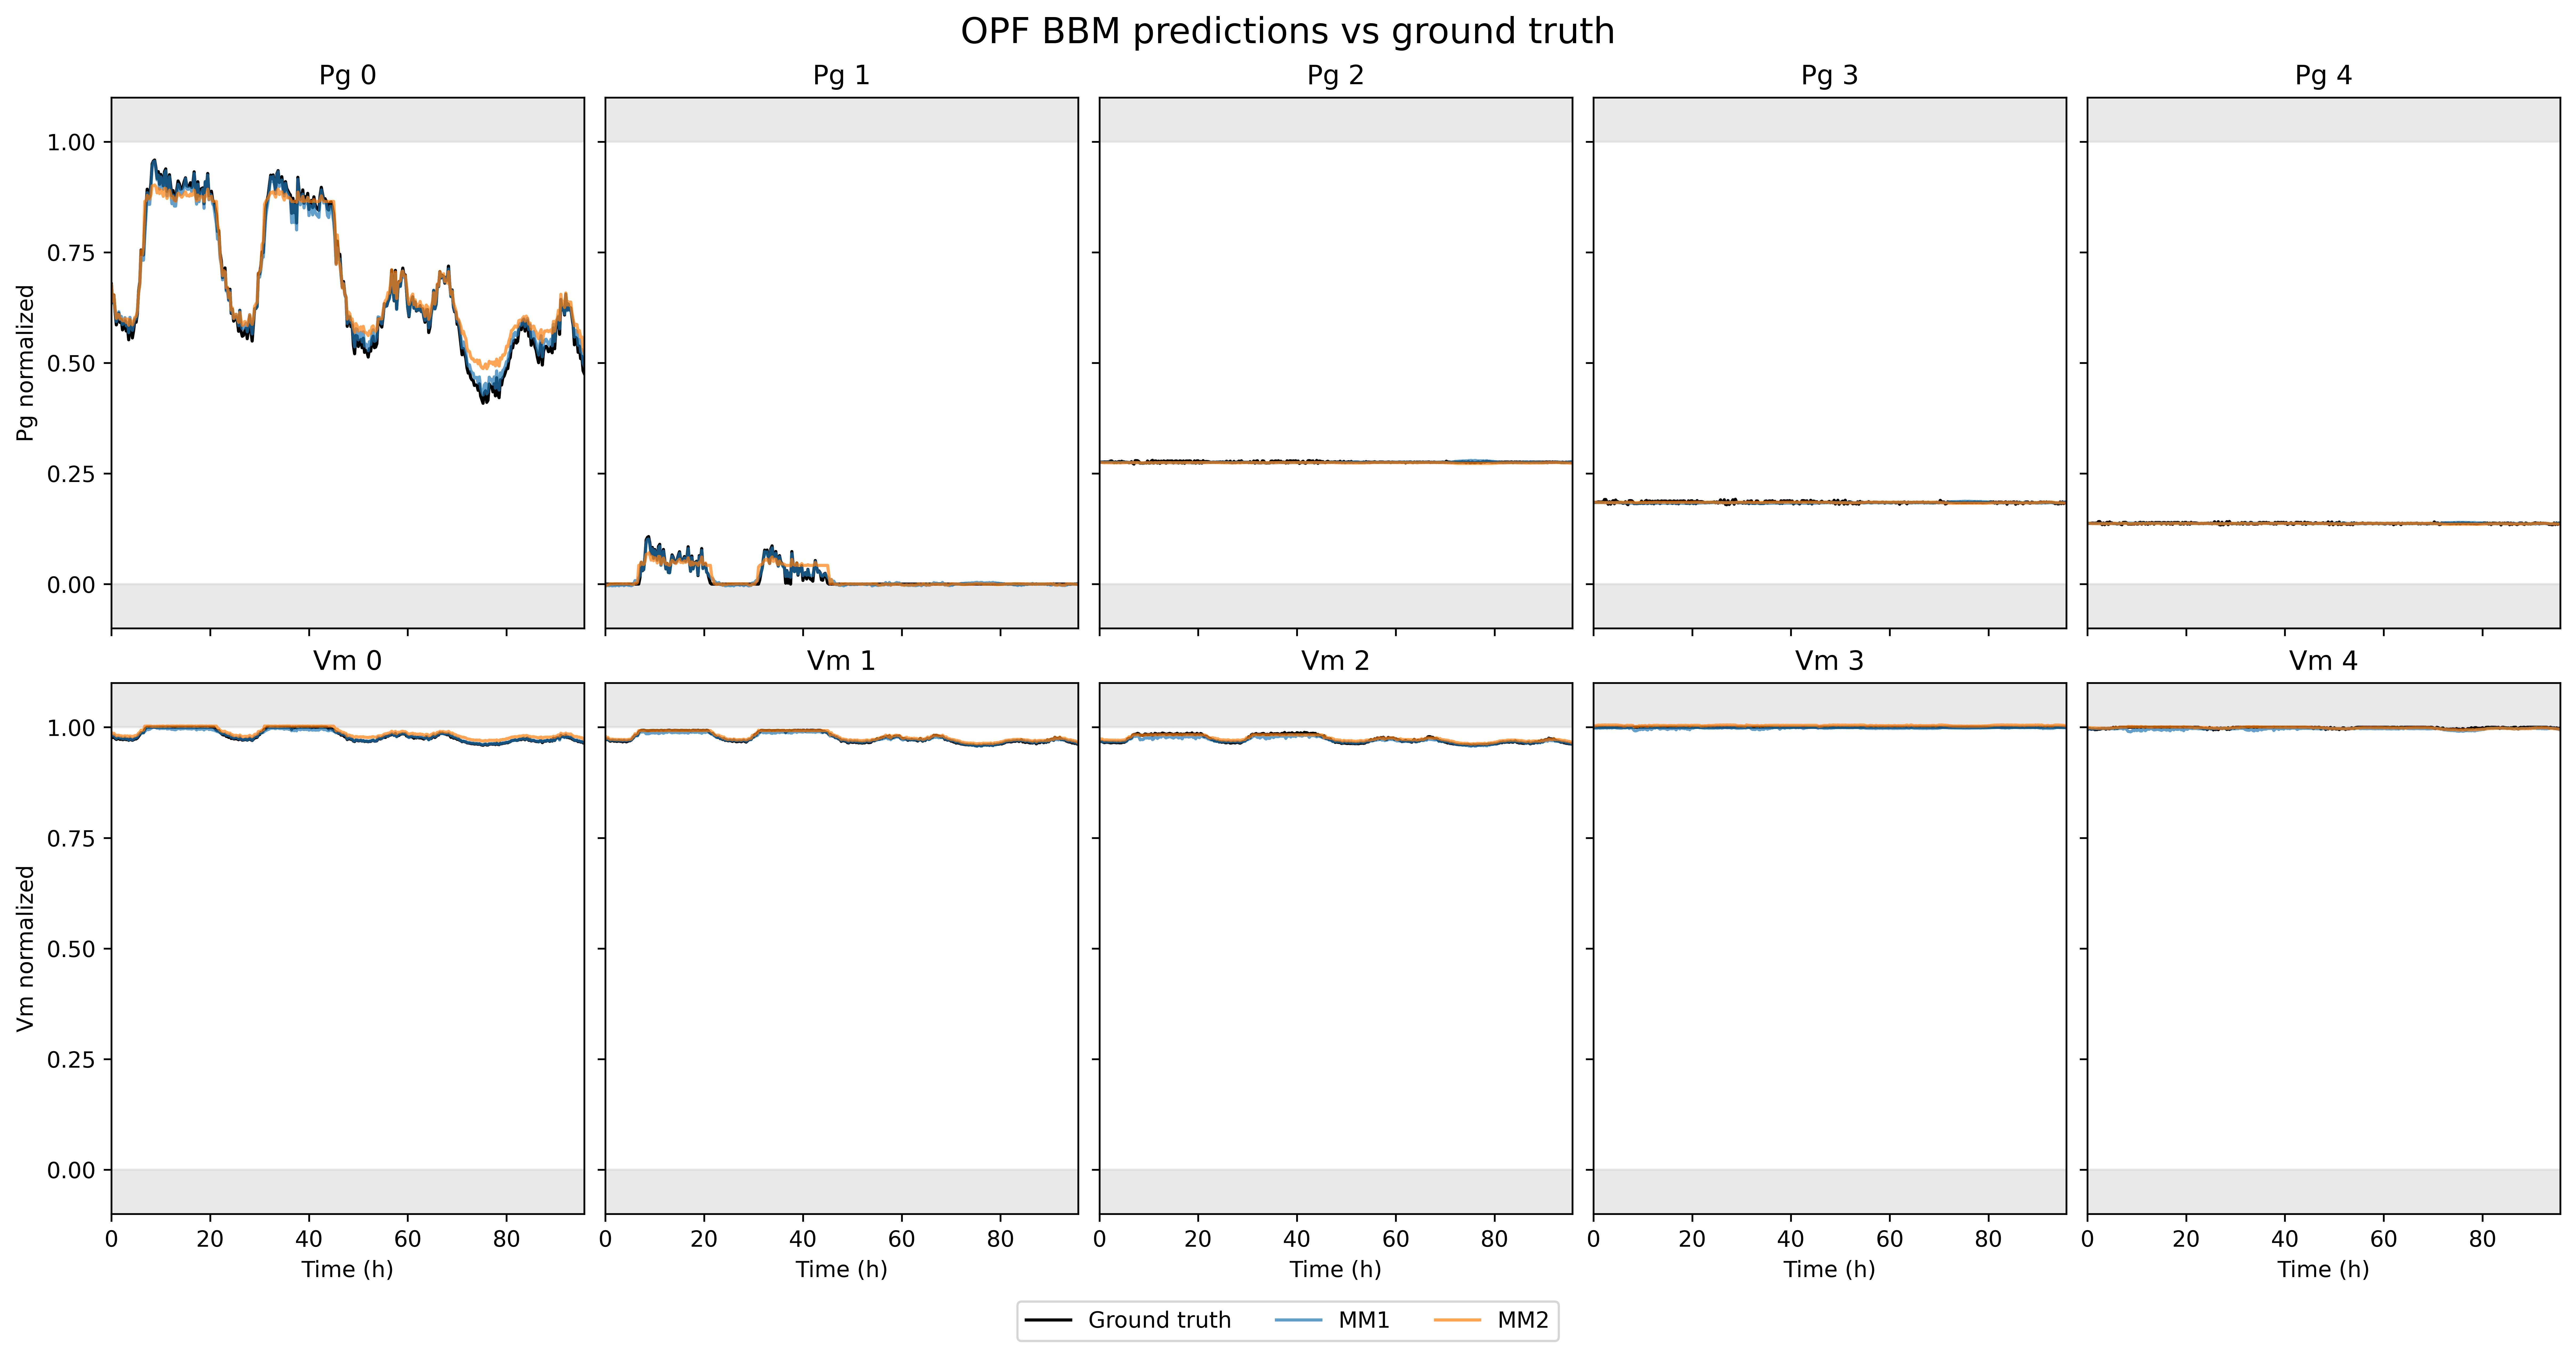

In [41]:
# Set ggplot
# plt.style.use("ggplot")

# Normal style
plt.style.use("default")

# Time
time = np.arange(0, len(output_data)) / 4
y_names = ["Pg normalized", "Vm normalized"]

# Calculate a nice number of rows and columns for the subplots
figsize = (16, 8)
output_size = output_data.shape[1]
cols = 5
rows = int(np.ceil(output_size / cols))

output_names = [f"Pg {i}" for i in range(5)] + [f"Vm {i}" for i in range(5)]

# Create the figure
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, dpi=600, sharex=True, sharey=True)
axs = axs.flatten()

# Plot the predictions versus the ground truth
for i in range(rows * cols):
    # Delete the axis if there is no data to plot
    if i >= output_size:
        axs[i // cols, i % cols].axis("off")
        continue

    # Plot the prediction versus the ground truth
    axs[i].plot(time, output_data[:, i].cpu().detach().numpy(), label="Ground truth", linewidth=1.4, color="black")
    axs[i].plot(time, pred_inputs[:, i].cpu().detach().numpy(), label="MM1", alpha=.7, linewidth=1.4)#, linestyle="--")
    axs[i].plot(time, pred_inputs2[:, i].cpu().detach().numpy(), label="MM2", alpha=.7, linewidth=1.4)#, linestyle=":")
    axs[i].set_title(f"{output_names[i]}")

    axs[i].set_xlim(0, time[-1])

    # Grey area outside the y limits
    axs[i].fill_between(time, 1, 2, color="lightgrey", alpha=0.5)
    axs[i].fill_between(time, 0, -1, color="lightgrey", alpha=0.5)


    # y ticks
    axs[i].set_ylim(-.1, 1.1)
    axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1])

    # If first column, add y label
    if i % cols == 0:
        axs[i].set_ylabel(y_names[i // cols])

    # If last row, add x label
    if i >= (rows - 1) * cols:
        axs[i].set_xlabel("Time (h)")

# Add figure title
fig.suptitle("OPF BBM predictions vs ground truth", fontsize=16)
# Add a legend at the bottom
_ = fig.legend(["Ground truth", "MM1", "MM2"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))

# Now for all the GT scenarios

In [1]:
import tqdm.notebook as tqdm
from pathlib import Path
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import greyboxmodels.bbmcpsmodels.creator as creator
import greyboxmodels.bbmcpsmodels.cyber.OPF as opf_bbm

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir("D:/projects/IPTLC_BBMs/")
print(f"Working directory: {os.getcwd()}")

Working directory: D:\projects\IPTLC_BBMs


In [17]:
data_folder = Path("data/OPF/20240311_011412")
gt_list = [f for f in os.listdir(data_folder) if f.startswith("gt_simulation") and f.endswith("minmax_normalized.npy")]

gt_inputs_list = [f for f in gt_list if "inputs" in f]
gt_outputs_list = [f for f in gt_list if "outputs" in f]

# Load one inputs/output to get the size
input_data = np.load(data_folder / gt_inputs_list[0])
output_data = np.load(data_folder / gt_outputs_list[0])

input_size = input_data.shape[1]
output_size = output_data.shape[1]

# Load the models
bbm1 = opf_bbm.BBM1_SimpleNet(input_size, output_size)
bbm1.load_state_dict(torch.load("models\BBM1_SimpleNet_MinMaxNormalizedOPF_20240314-114822.pt"))
bbm1.to(device)
_ = bbm1.eval()

bbm2 = opf_bbm.BBM2_DeepNN(input_size, output_size)
bbm2.load_state_dict(torch.load("models\BBM2-deep_MinMaxNormalizedOPF_20240314-120950.pt"))
bbm2.to(device)
_ = bbm2.eval()

# Loop
for input_loc, output_loc in tqdm.tqdm(zip(gt_inputs_list, gt_outputs_list), total=len(gt_inputs_list)):
    # Open the gt data
    input_data = np.load(data_folder / input_loc)
    output_data = np.load(data_folder / output_loc)

    # tensorize the data
    input_data = torch.from_numpy(input_data).float().to(device)
    output_data = torch.from_numpy(output_data).float().to(device)

    # Predictions
    pred_inputs = bbm1(input_data)
    pred_inputs2 = bbm2(input_data)

    # Normal style
    plt.style.use("default")

    # Time
    time = np.arange(0, len(output_data)) / 4
    y_output_names = ["Pg normalized", "Vm normalized"]

    # Calculate a nice number of rows and columns for the subplots
    figsize = (16, 8)
    output_size = output_data.shape[1]
    cols = 5
    rows = int(np.ceil(output_size / cols))

    output_names = [f"Pg {i}" for i in range(5)] + [f"Vm {i}" for i in range(5)]

    # Create the figure
    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, dpi=600, sharex=True, sharey=True)
    axs = axs.flatten()

    # Plot the predictions versus the ground truth
    for i in range(rows * cols):
        # Delete the axis if there is no data to plot
        if i >= output_size:
            axs[i // cols, i % cols].axis("off")
            continue

        # Plot the prediction versus the ground truth
        axs[i].plot(time, output_data[:, i].cpu().detach().numpy(), label="Ground truth", linewidth=1.4, color="black")
        axs[i].plot(time, pred_inputs[:, i].cpu().detach().numpy(), label="MM1", alpha=.7, linewidth=1.4)#, linestyle="--")
        axs[i].plot(time, pred_inputs2[:, i].cpu().detach().numpy(), label="MM2", alpha=.7, linewidth=1.4)#, linestyle=":")
        axs[i].set_title(f"{output_names[i]}")

        axs[i].set_xlim(0, time[-1])

        # Grey area outside the y limits
        axs[i].fill_between(time, 1, 2, color="lightgrey", alpha=0.5)
        axs[i].fill_between(time, 0, -1, color="lightgrey", alpha=0.5)


        # y ticks
        axs[i].set_ylim(-.1, 1.1)
        axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1])

        # If first column, add y label
        if i % cols == 0:
            axs[i].set_ylabel(y_output_names[i // cols])

        # If last row, add x label
        if i >= (rows - 1) * cols:
            axs[i].set_xlabel("Time (h)")

    # Add figure title
    scenario_name = int(input_loc.split("_")[2])
    fig.suptitle(f"OPF BBM predictions vs ground truth - Scenario {scenario_name}", fontsize=16)

    # Add a legend at the bottom
    _ = fig.legend(["Ground truth", "MM1", "MM2"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))

    # Save the figure
    print(f"Saving figure for scenario {scenario_name}")
    fig.savefig(f"figures/OPF_BBMs_predictions_scenario_{scenario_name}.png", bbox_inches="tight")
    plt.close(fig)

  0%|          | 0/8 [00:00<?, ?it/s]

Saving figure for scenario 0
Saving figure for scenario 114
Saving figure for scenario 116
Saving figure for scenario 2
Saving figure for scenario 35
Saving figure for scenario 3
Saving figure for scenario 4
Saving figure for scenario 5


In [6]:
# INPUTS
data_folder = Path("data/OPF/20240311_011412")
gt_list = [f for f in os.listdir(data_folder) if f.startswith("gt_simulation") and f.endswith("minmax_normalized.npy")]

gt_inputs_list = [f for f in gt_list if "inputs" in f]
gt_outputs_list = [f for f in gt_list if "outputs" in f]

# Load one inputs/output to get the size
input_data = np.load(data_folder / gt_inputs_list[0])
output_data = np.load(data_folder / gt_outputs_list[0])

input_size = input_data.shape[1]
output_size = output_data.shape[1]

 # Calculate a nice number of rows and columns for the subplots
figsize = (32, 16)
cols = 3
rows = int(np.ceil(input_size / cols))

# Loop
for input_loc, output_loc in tqdm.tqdm(zip(gt_inputs_list, gt_outputs_list), total=len(gt_inputs_list)):
    # Open the gt data
    input_data = np.load(data_folder / input_loc)
    output_data = np.load(data_folder / output_loc)

    # Time
    time = np.arange(0, len(output_data)) / 4

    # Create the figure
    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, dpi=600, sharex=True)
    axs = axs.flatten()

    # Plot the predictions versus the ground truth
    for i in range(rows * cols):
        if i >= input_size:
            axs[i].axis("off")
            continue

        # Plot the prediction versus the ground truth
        axs[i].plot(time, input_data[:, i], label="Ground truth", linewidth=1.4, color="black")
        #
        axs[i].set_xlim(0, time[-1])
        #
        # # Grey area outside the y limits
        # axs[i].fill_between(time, 1, 2, color="lightgrey", alpha=0.5)
        # axs[i].fill_between(time, 0, -1, color="lightgrey", alpha=0.5)
        #
        #

        if i > 26:
            # Do a grey area
            axs[i].fill_between(time, -2, 2, color="lightgrey", alpha=0.5)

        # y ticks
        axs[i].set_ylim(-.1, 1.1)
        axs[i].set_yticks([0, 1])

        #
        # # If first column, add y label
        # if i % cols == 0:
        #     axs[i].set_ylabel(y_output_names[i // cols])
        #
        # If last row, add x label

    # Add figure title
    scenario_name = int(input_loc.split("_")[2])
    fig.suptitle(f"Inputs - Scenario {scenario_name}", fontsize=16)

    # Save the figure
    print(f"Saving figure for scenario {scenario_name}")
    fig.savefig(f"figures/OPF_BBMs_inputs_scenario_{scenario_name}.png", bbox_inches="tight")
    plt.close(fig)

  0%|          | 0/8 [00:00<?, ?it/s]

Saving figure for scenario 0
Saving figure for scenario 114
Saving figure for scenario 116
Saving figure for scenario 2
Saving figure for scenario 35
Saving figure for scenario 3
Saving figure for scenario 4
Saving figure for scenario 5


In [17]:
input_size

52

In [ ]:
data_folder = Path("data/OPF/20240311_011412")
gt_list = [f for f in os.listdir(data_folder) if f.startswith("gt_simulation") and f.endswith("minmax_normalized.npy")]

gt_inputs_list = [f for f in gt_list if "inputs" in f]
gt_outputs_list = [f for f in gt_list if "outputs" in f]

# Load the models
bbm1 = opf_bbm.BBM1_SimpleNet(input_size, output_size)
bbm1.load_state_dict(torch.load("models\BBM1_SimpleNet_MinMaxNormalizedOPF_20240314-114822.pt"))
bbm1.to(device)
_ = bbm1.eval()

bbm2 = opf_bbm.BBM2_DeepNN(input_size, output_size)
bbm2.load_state_dict(torch.load("models\BBM2-deep_MinMaxNormalizedOPF_20240314-120950.pt"))
bbm2.to(device)
_ = bbm2.eval()

# Loop
for input_loc, output_loc in tqdm.tqdm(zip(gt_inputs_list, gt_outputs_list), total=len(gt_inputs_list)):
    # Open the gt data
    input_data = np.load(data_folder / input_loc)
    output_data = np.load(data_folder / output_loc)

    # tensorize the data
    input_data = torch.from_numpy(input_data).float().to(device)
    output_data = torch.from_numpy(output_data).float().to(device)

    # Predictions
    pred_output_bbm1 = bbm1(input_data)
    pred_output_bbm2 = bbm2(input_data)

    # Normal style
    plt.style.use("default")

    # Time
    time = np.arange(0, len(output_data)) / 4
    y_output_names = ["Pg normalized", "Vm normalized"]

    # Calculate a nice number of rows and columns for the subplots
    figsize = (16, 8)
    output_size = output_data.shape[1]
    cols = 5
    rows = int(np.ceil(output_size / cols))

    output_names = [f"Pg {i}" for i in range(5)] + [f"Vm {i}" for i in range(5)]

    # Create the figure
    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, dpi=600, sharex=True, sharey=True)
    axs = axs.flatten()

    # Plot the predictions versus the ground truth
    for i in range(rows * cols):
        # Delete the axis if there is no data to plot
        if i >= output_size:
            axs[i // cols, i % cols].axis("off")
            continue

        # Plot the prediction versus the ground truth
        axs[i].plot(time, output_data[:, i].cpu().detach().numpy(), label="Ground truth", linewidth=1.4, color="black")
        axs[i].plot(time, pred_output_bbm1[:, i].cpu().detach().numpy(), label="MM1", alpha=.7, linewidth=1.4)#, linestyle="--")
        axs[i].plot(time, pred_output_bbm2[:, i].cpu().detach().numpy(), label="MM2", alpha=.7, linewidth=1.4)#, linestyle=":")
        axs[i].set_title(f"{output_names[i]}")

        axs[i].set_xlim(0, time[-1])

        # Grey area outside the y limits
        axs[i].fill_between(time, 1, 2, color="lightgrey", alpha=0.5)
        axs[i].fill_between(time, 0, -1, color="lightgrey", alpha=0.5)


        # y ticks
        axs[i].set_ylim(-.1, 1.1)
        axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1])

        # If first column, add y label
        if i % cols == 0:
            axs[i].set_ylabel(y_names[i // cols])

        # If last row, add x label
        if i >= (rows - 1) * cols:
            axs[i].set_xlabel("Time (h)")

    # Add figure title
    scenario_name = int(input_loc.split("_")[2])
    fig.suptitle(f"OPF BBM predictions vs ground truth - Scenario {scenario_name}", fontsize=16)

    # Add a legend at the bottom
    _ = fig.legend(["Ground truth", "MM1", "MM2"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))

    # Save the figure
    print(f"Saving figure for scenario {scenario_name}")
    fig.savefig(f"figures/OPF_BBMs_predictions_scenario_{scenario_name}.png", bbox_inches="tight")
    plt.close(fig)

In [29]:
# Specify the paths
datasets_folder = Path("data/OPF/2023-12-06_18-00-46")

# Let's open single simulation
single_input_normalized = np.load(datasets_folder / Path("OPF-NI1-O3/single_input.npy"))
single_input_raw = np.load(datasets_folder / Path("OPF-I1-O3/single_input.npy"))
single_output = np.load(datasets_folder / Path("OPF-I1-O3/single_output.npy"))

# Convert to torch tensors
single_input_normalized = torch.from_numpy(single_input_normalized).float().to(device)
single_input_raw = torch.from_numpy(single_input_raw).float().to(device)
single_output = torch.from_numpy(single_output).float().to(device)

In [31]:
# Size of the input and output
input_size = single_input_normalized.shape[1]
output_size = single_output.shape[1]

print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

([WindowsPath('data/OPF/20240311_011412/gt_simulation_0_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_114_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_116_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_2_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_35_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_3_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_4_inputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_5_inputs_minmax_normalized.npy')],
 [WindowsPath('data/OPF/20240311_011412/gt_simulation_0_outputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_114_outputs_minmax_normalized.npy'),
  WindowsPath('data/OPF/20240311_011412/gt_simulation_116_outputs_minmax_normalized.npy'),
  WindowsPath('data

In [37]:
# Load the single example dataframes to extract the input/output names from the columns
input_df = pd.read_csv(datasets_folder / Path("OPF-I1-O3/single_input.csv"), index_col=0)
output_df = pd.read_csv(datasets_folder / Path("OPF-I1-O3/single_output.csv"), index_col=0)

# Get the names of the inputs and outputs
input_names = input_df.columns.values.tolist()
output_names = output_df.columns.values.tolist()

  0%|          | 0/8 [00:00<?, ?it/s]

Saving figure to figures\OPF-BBM_comparison_gt_simulation_0.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_114.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_116.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_2.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_35.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_3.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_4.png
Saving figure to figures\OPF-BBM_comparison_gt_simulation_5.png


In [14]:
# Load the models trained with the normalized dataset
OPF_BBM_1_normalized = opf_models.Net(input_size, output_size)
OPF_BBM_1_normalized.load_state_dict(torch.load("models/BBM1-2layers_OPF-NI1-O3_20240201-110613.pt"))
OPF_BBM_1_normalized.to(device)
OPF_BBM_1_normalized.eval()

OPF_BBM_2_normalized = opf_models.DeepNN(input_size, output_size)
OPF_BBM_2_normalized.load_state_dict(torch.load("models/BBM2-deep_OPF-NI1-O3_20240201-112030_best.pt"))
OPF_BBM_2_normalized.to(device)
OPF_BBM_2_normalized.eval()

# Load the models trained with the raw dataset
OPF_BBM_1_raw = opf_models.Net(input_size, output_size)
OPF_BBM_1_raw.load_state_dict(torch.load("models/BBM1-2layers_OPF-I1-O3_20240201-111317.pt"))
OPF_BBM_1_raw.to(device)
OPF_BBM_1_raw.eval()


BBM1_SimpleNet(
  (fc1): Linear(in_features=53, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=9, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

In [25]:
## Predictions using BBM1 with raw and normalized data
# Predictions using the normalized dataset and BBM1
prediction_normalized_1 = OPF_BBM_1_normalized(single_input_normalized)

# Predictions using the raw dataset and BBM1
prediction_raw_1 = OPF_BBM_1_raw(single_input_raw)
# Plot the predictions versus the ground truth
# Obtain the size of the output. THen, create an equal number of subplots and plot predictions versus ground truth in each subplot
print(f"Output size: {output_size}")

# Calculate a nice number of rows and columns for the subplots
figsize = (20, 10)
rows = int(np.sqrt(output_size))
cols = int(np.ceil(output_size / rows))

# Create the figure
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

try:
    y_limits
except NameError:
    y_limits = None

# Plot the predictions versus the ground truth
for i in range(rows * cols):
    # Delete the axis if there is no data to plot
    if i >= output_size:
        axs[i // cols, i % cols].axis("off")
        continue

    # Calculate the row and column of the subplot
    row = i // cols
    col = i % cols

    # Plot the prediction versus the ground truth
    axs[row, col].plot(single_output[:, i].cpu().detach().numpy(), label="Ground truth", color="black")
    axs[row, col].plot(prediction_raw_1[:, i].cpu().detach().numpy(), label="Prediction (raw input)", color="black",
                       linestyle="--")
    axs[row, col].plot(prediction_normalized_1[:, i].cpu().detach().numpy(), label="Prediction (normalized input)",
                       color="black", linestyle=":")
    axs[row, col].set_title(output_names[i])

    # Set the x limit
    axs[row, col].set_xlim([0, 96])

    # Set the y limit
    if y_limits is not None:
        # get the current y limits
        this_y_bot, this_y_up = axs[row, col].get_ylim()
        gen_y_bot, gen_y_up = y_limits[i]

        # check both limits: if bottom limit is lower than the current one, update it and viceversa
        if this_y_bot < gen_y_bot:
            y_limits[i][0] = this_y_bot
        if this_y_up > gen_y_up:
            y_limits[i][1] = this_y_up

        # set the limits
        axs[row, col].set_ylim(y_limits[i])

# Add a legend at the top
_ = fig.legend(["Ground truth", "Prediction (raw input)", "Prediction (normalized input)"], loc="upper center", ncol=3,bbox_to_anchor=(0.5, 1.05))

-0.16389999999999993

In [27]:
# Predictions using the normalized dataset and BBM1
prediction_normalized_2 = OPF_BBM_2_normalized(single_input_normalized)

301 µs ± 87.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
# Plot the predictions versus the ground truth
# Obtain the size of the output. THen, create an equal number of subplots and plot predictions versus ground truth in each subplot
output_size = single_output.shape[1]
print(f"Output size: {output_size}")

# Calculate a nice number of rows and columns for the subplots
figsize = (20, 10)
rows = int(np.sqrt(output_size))
cols = int(np.ceil(output_size / rows))

# Create the figure
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

# Plot the predictions versus the ground truth
for i in range(rows * cols):
    # Delete the axis if there is no data to plot
    if i >= output_size:
        axs[i // cols, i % cols].axis("off")
        continue

    # Calculate the row and column of the subplot
    row = i // cols
    col = i % cols

    # Plot the prediction versus the ground truth
    axs[row, col].plot(single_output[:, i].cpu().detach().numpy(), label="Ground truth", color="black")
    axs[row, col].plot(prediction_normalized_1[:, i].cpu().detach().numpy(), label="Prediction (BBM1)", color="black", linestyle=":")
    axs[row, col].plot(prediction_normalized_2[:, i].cpu().detach().numpy(), label="Prediction (BBM2)", color="red", linestyle="-.")
    axs[row, col].set_title(output_names[i])

    # Set the x limit
    axs[row, col].set_xlim([0, 96])

    # Set the y limit
    if y_limits is not None:
        # get the current y limits
        this_y_bot, this_y_up = axs[row, col].get_ylim()
        gen_y_bot, gen_y_up = y_limits[i]

        # check both limits: if bottom limit is lower than the current one, update it and viceversa
        if this_y_bot < gen_y_bot:
            y_limits[i][0] = this_y_bot
        if this_y_up > gen_y_up:
            y_limits[i][1] = this_y_up

        # set the limits
        axs[row, col].set_ylim(y_limits[i])

# Add a legend at the top
_ = fig.legend(["Ground truth", "Prediction (BBM1)", "Prediction (BBM2)"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))

1.2499999999999999e-05